In [2]:
%load_ext autoreload
%autoreload 2

bierz f1, f beta score <-

podzielic proces engineering na krotkie teksty i dlugie teksty.
dwa rozne problemy
np powyzej 10 tokenow to juz artykul, a ponizej to krotka wypowiedz i uzyc dwoch roznych modeli.

nie tracic czasu - grid search ale 10% rekordow

jakie modele:
NLP? MLP?

robic krzywa roc, auc i porownywac

jaki model? raczej random forest na 50%


In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
d1 = pd.read_csv('../../data_for_modeling/ClaimsKG_for_modeling.csv')
d2 = pd.read_csv('../../data_for_modeling/English_fake_for_modeling.csv')
d3 = pd.read_csv('../../data_for_modeling/fake-news-detection-for_modeling.csv')
d4 = pd.read_csv('../../data_for_modeling/ISOT_for_modeling.csv')
d5 = pd.read_csv('../../data_for_modeling/LIAR_for_modeling.csv')
d6 = pd.read_csv('../../data_for_modeling/WELFake_for_modeling.csv')



In [5]:
d3.head()
#rename column title_text to text
d3 = d3.rename(columns={'title_text': 'text'})
d3.head()

,text,fake
0,Foreign Democrat final. more tax development b...,0
1,To offer down resource great point. probably g...,1
2,Himself church myself carry. them identify for...,1
3,You unit its should. phone which item yard Rep...,1
4,Billion believe employee summer how. wonder my...,1


In [6]:
d4.head()

,title,text,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0


In [7]:
# połącz title i text w kolumnę text
d4['text'] = d4['title'] + ' ' + d4['text']
d4 = d4.drop(columns=['title'])
d4.head()

,text,fake
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [9]:
dataset_all = pd.concat([d1, d2, d3, d4, d5, d6], ignore_index=True)

In [10]:
dataset_copy = dataset_all.copy() # just in case

In [11]:
dataset_all.shape

(168228, 2)

In [12]:
dataset_all.duplicated().sum()

7268

In [13]:
dataset_all.drop_duplicates(inplace=True)

In [14]:
dataset_all.shape

(160960, 2)

In [22]:
import ninja_utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dominikakokoryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dominikakokoryk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## wykresy

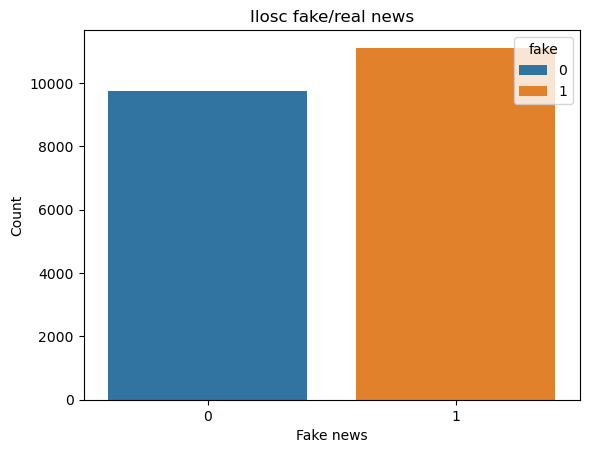

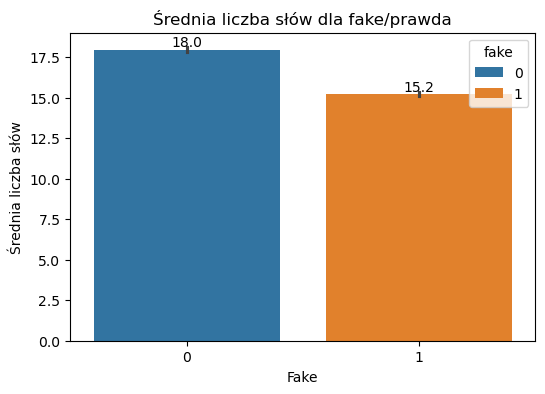

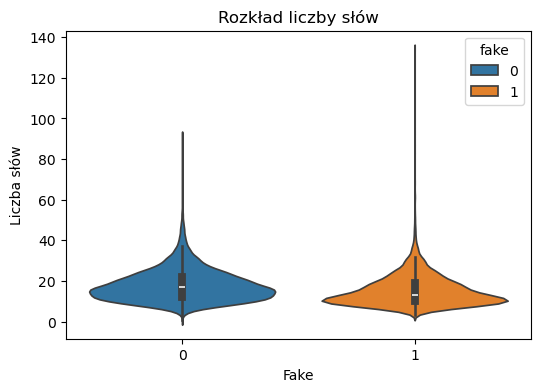

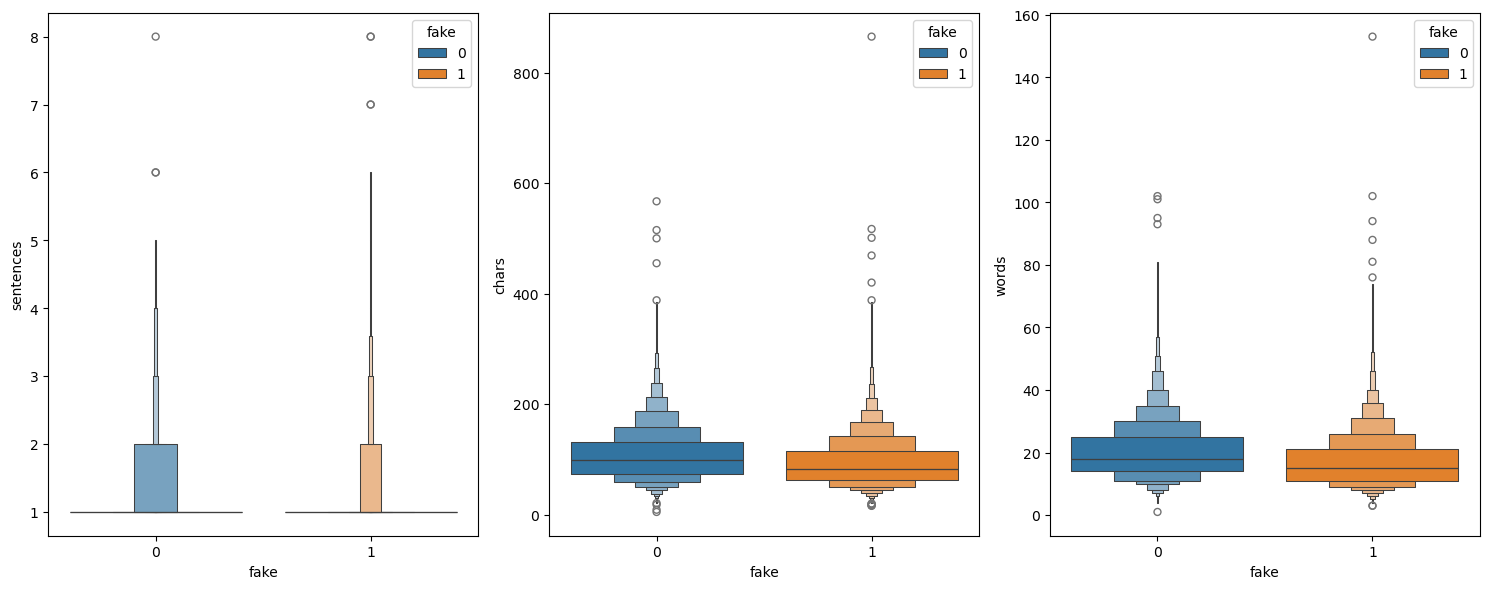

In [16]:
ninja_utils.plot_plots_dataset(d1)

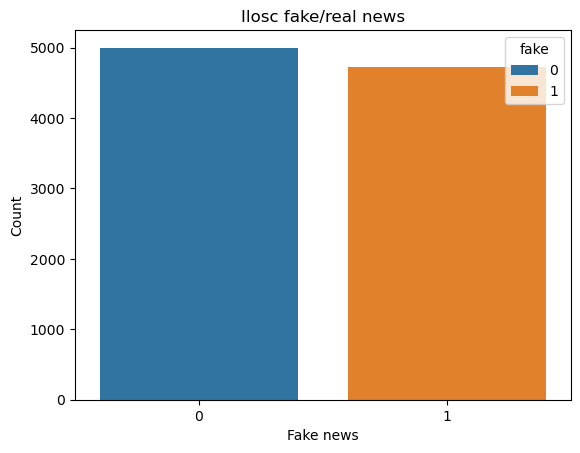

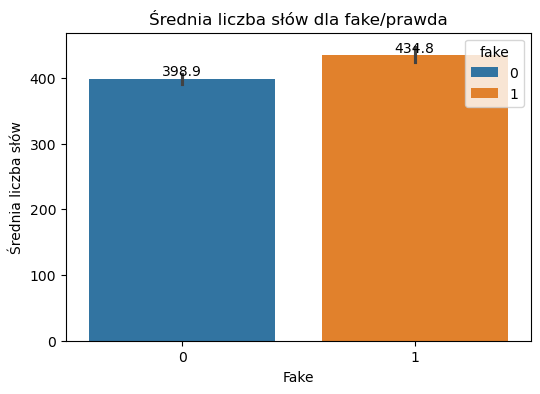

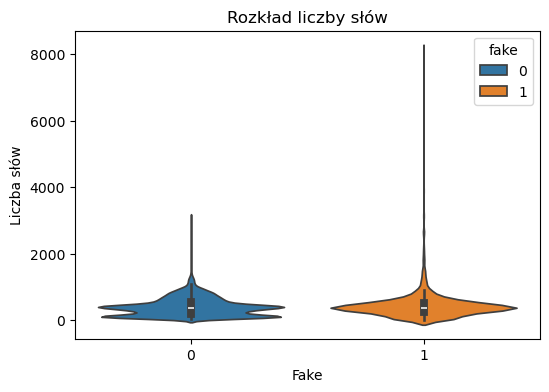

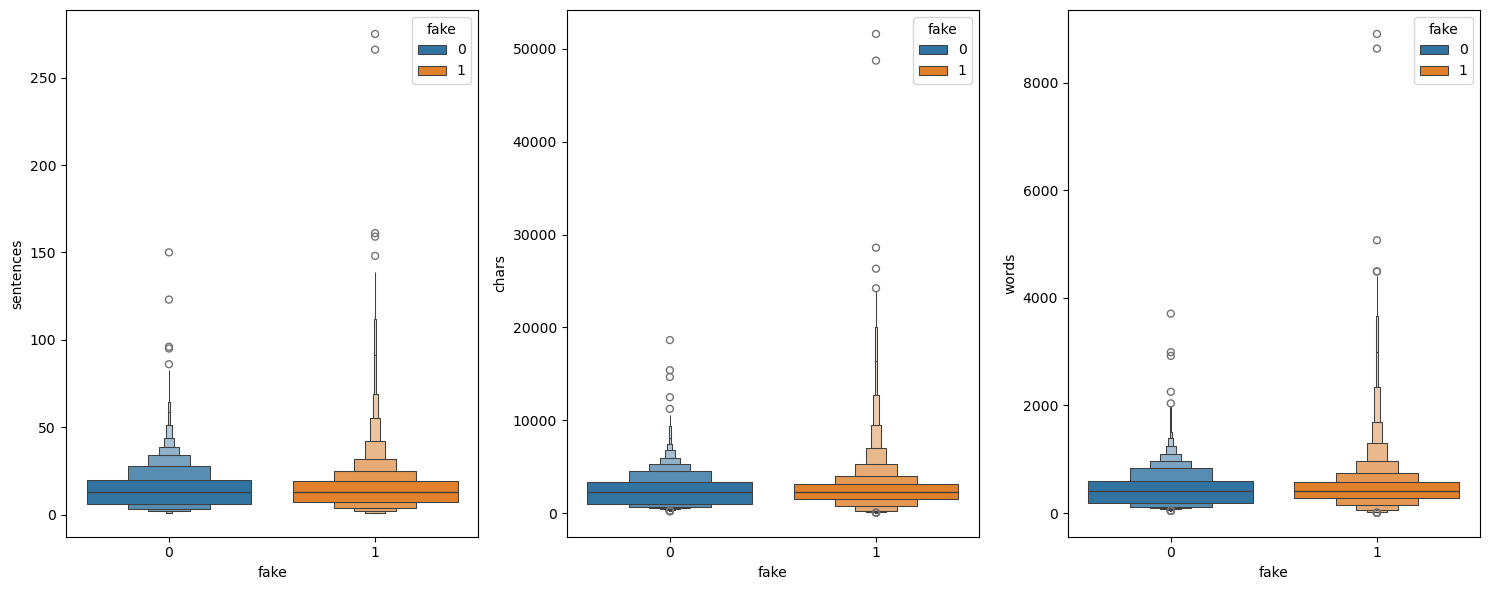

In [ ]:
ninja_utils.plot_plots_dataset(d2)

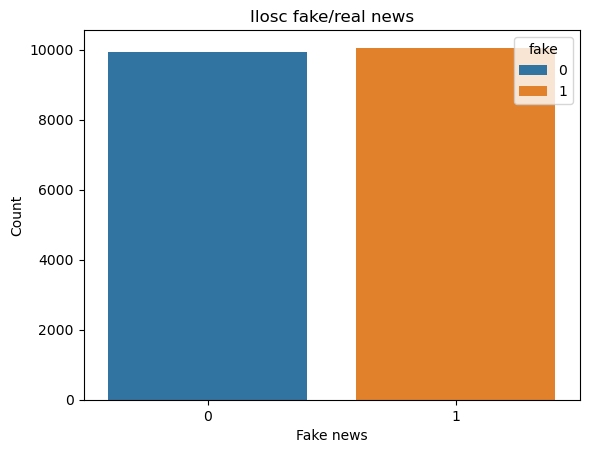

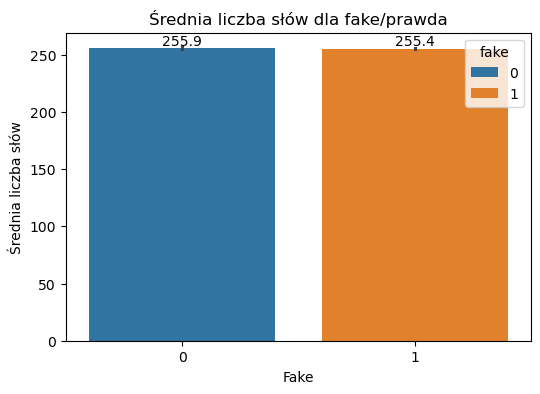

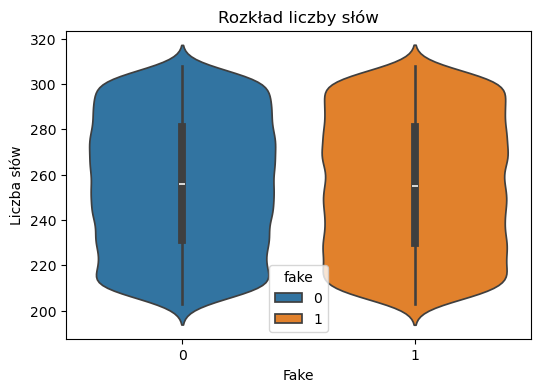

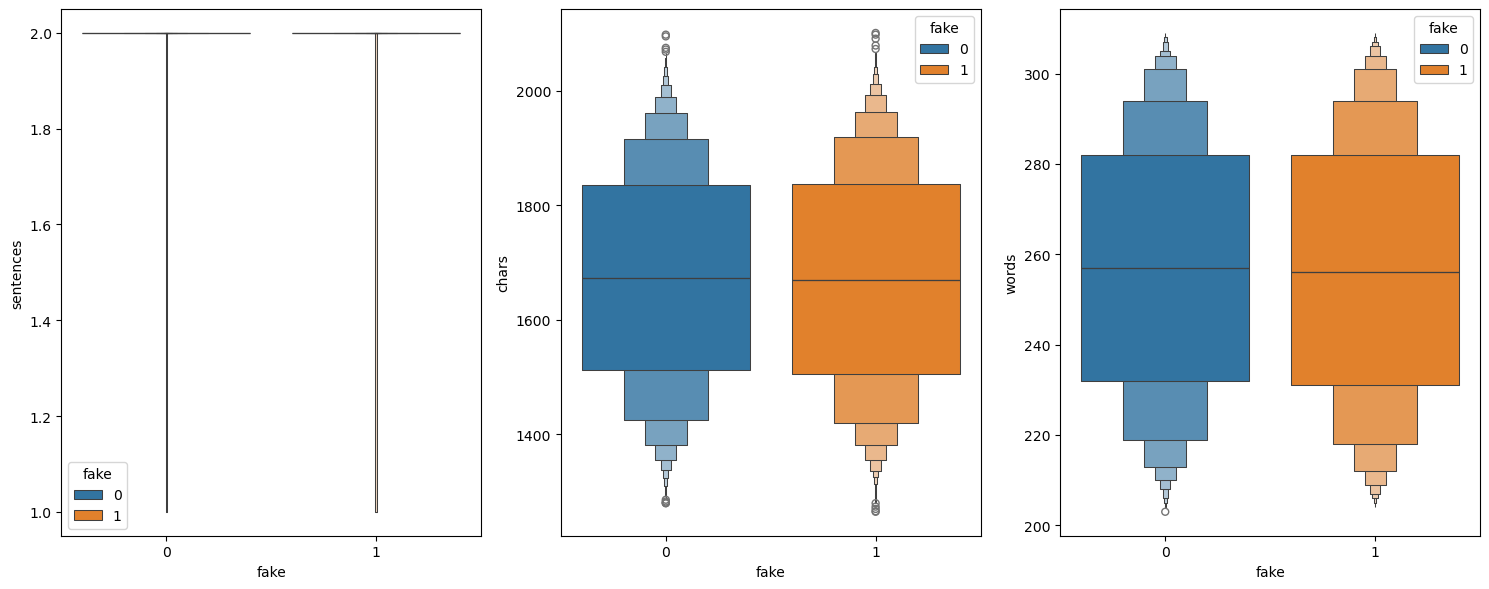

In [ ]:
ninja_utils.plot_plots_dataset(d3)

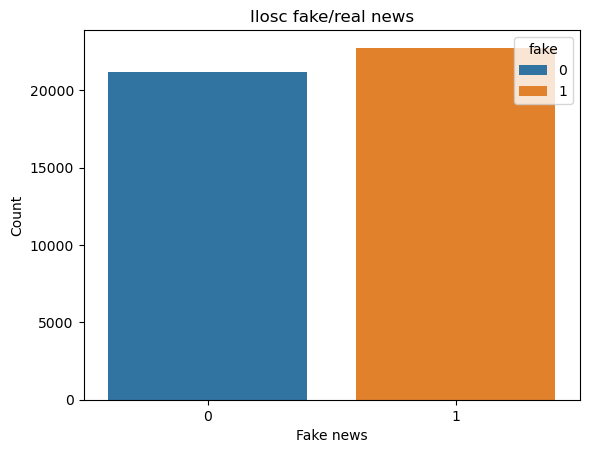

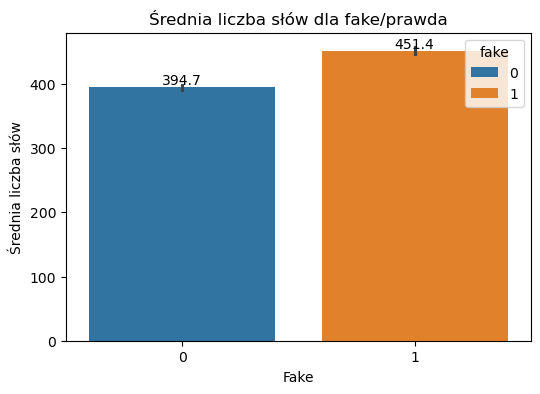

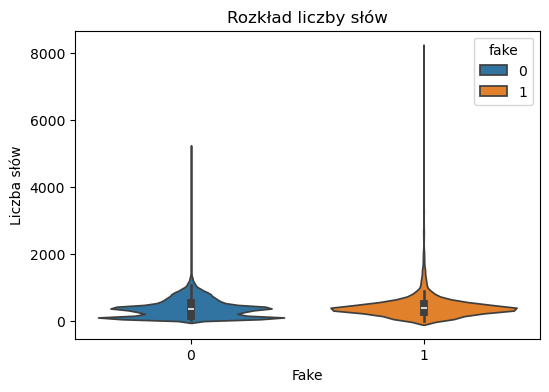

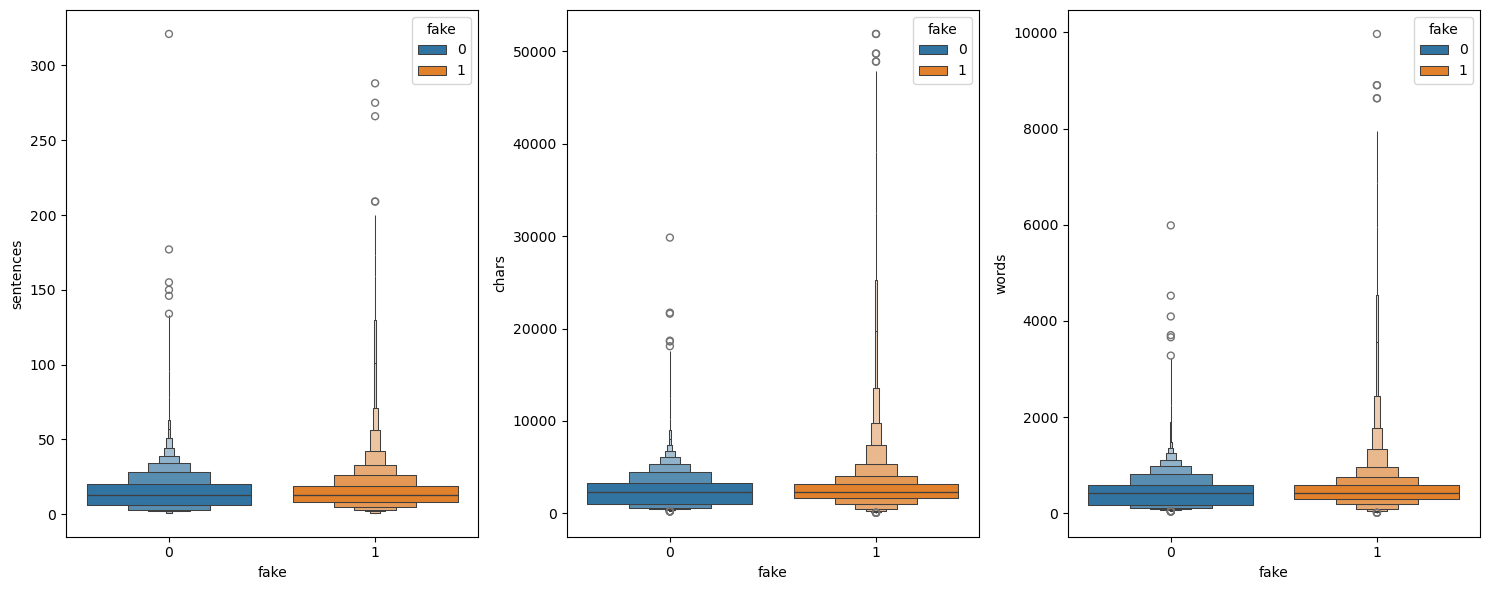

In [ ]:
ninja_utils.plot_plots_dataset(d4)

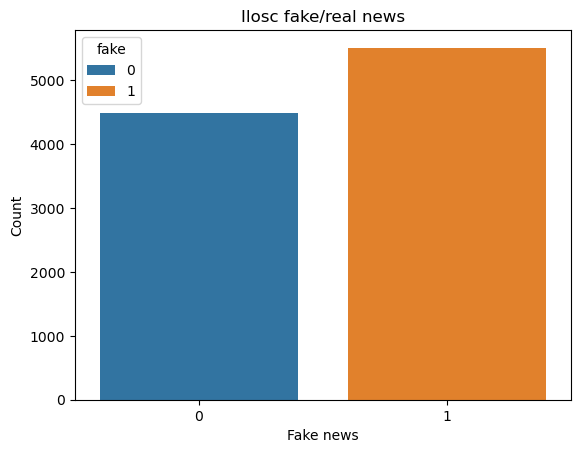

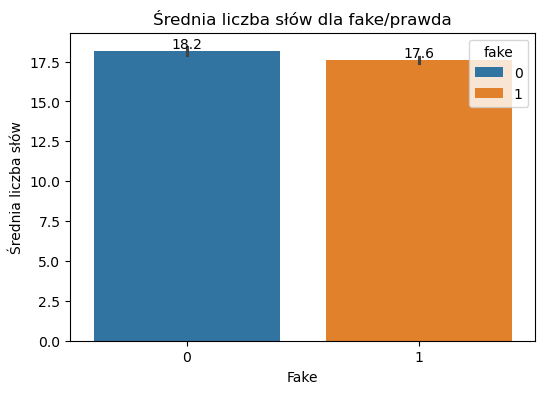

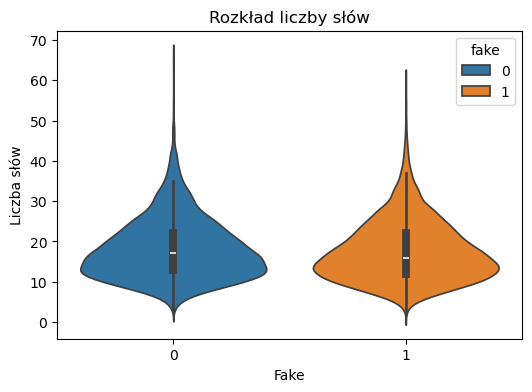

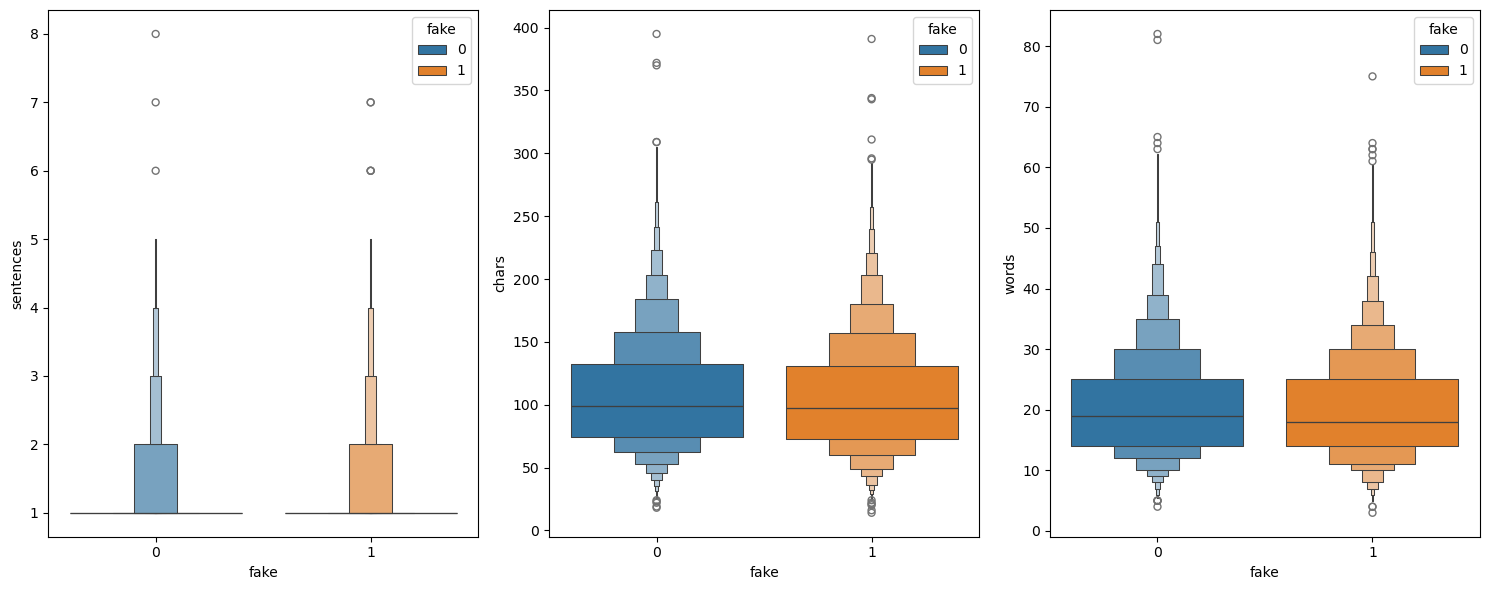

In [ ]:
ninja_utils.plot_plots_dataset(d5)

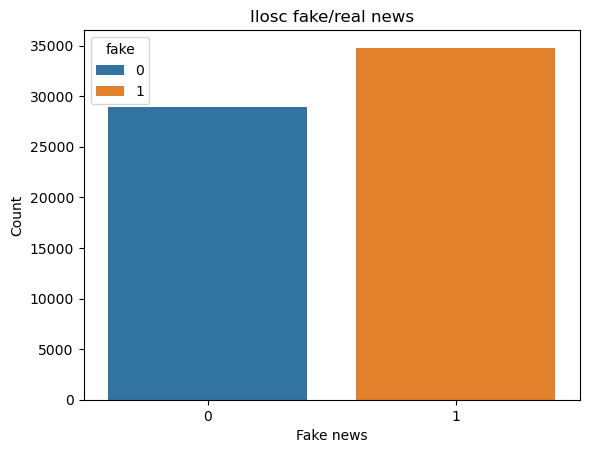

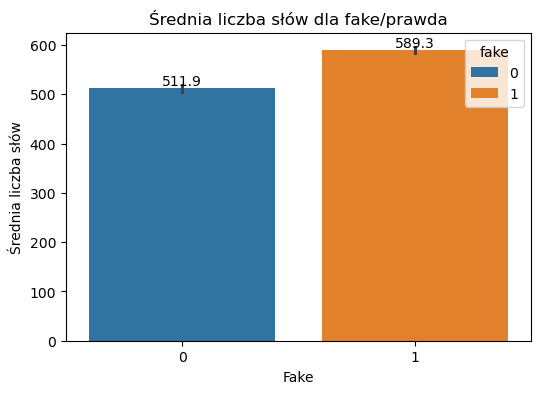

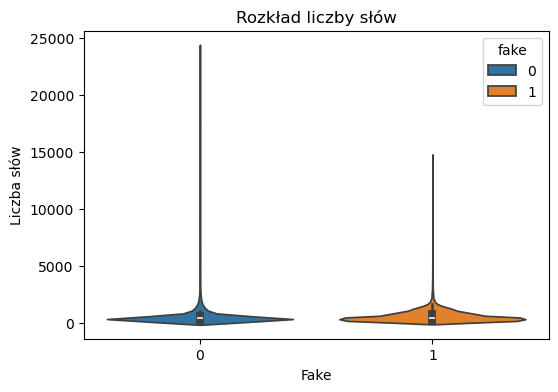

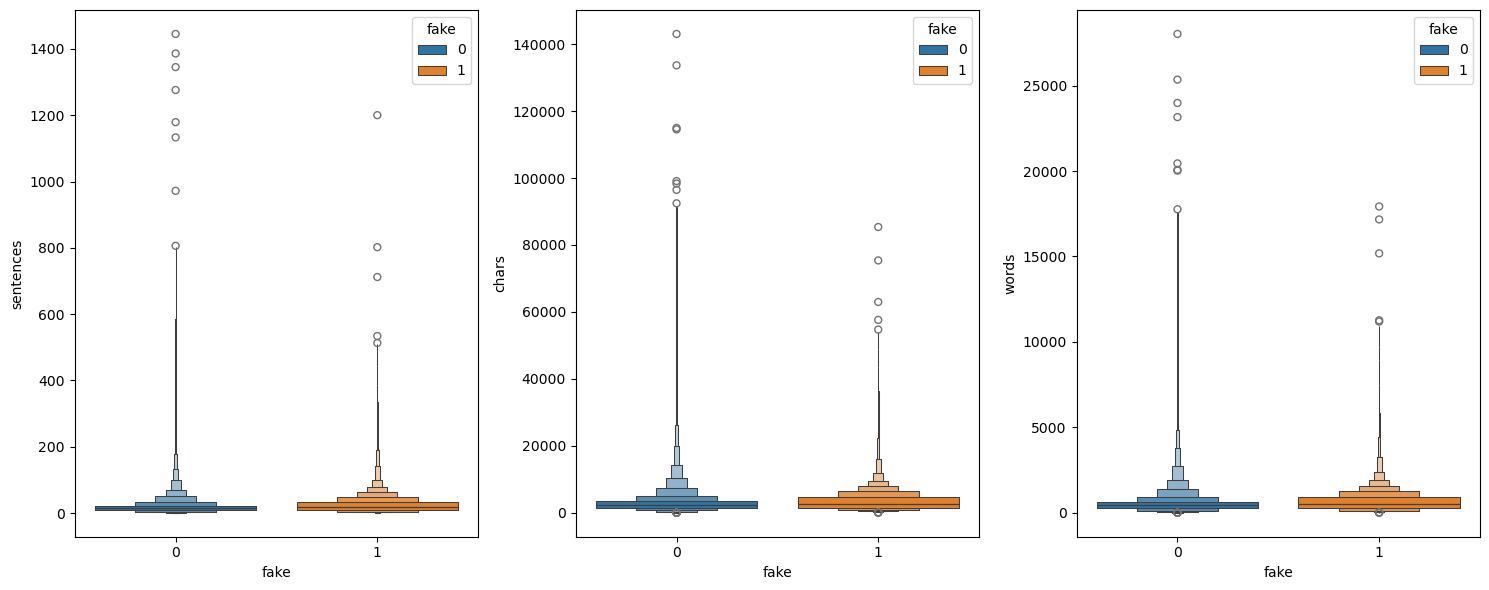

In [ ]:
ninja_utils.plot_plots_dataset(d6)

## cos innego zeby zwinac wykresy

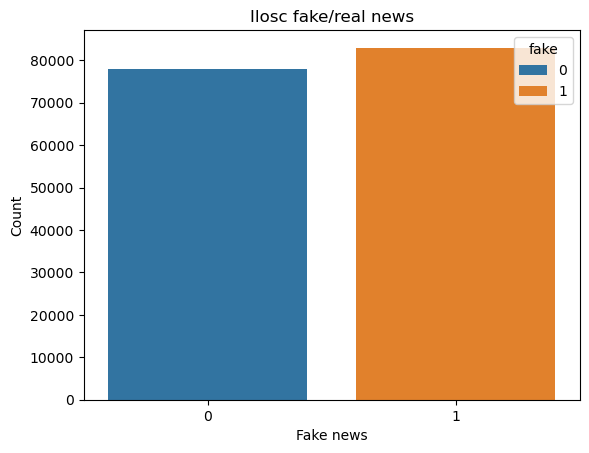

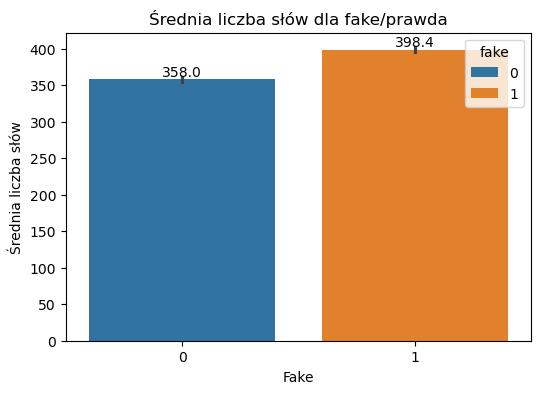

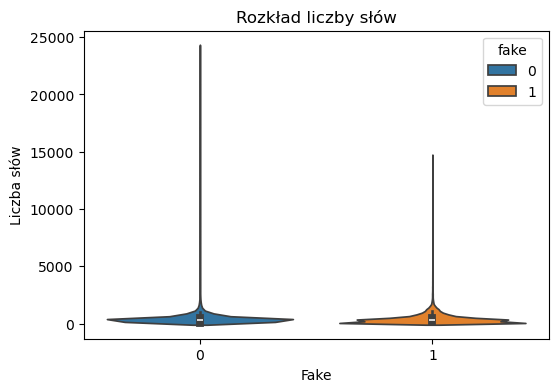

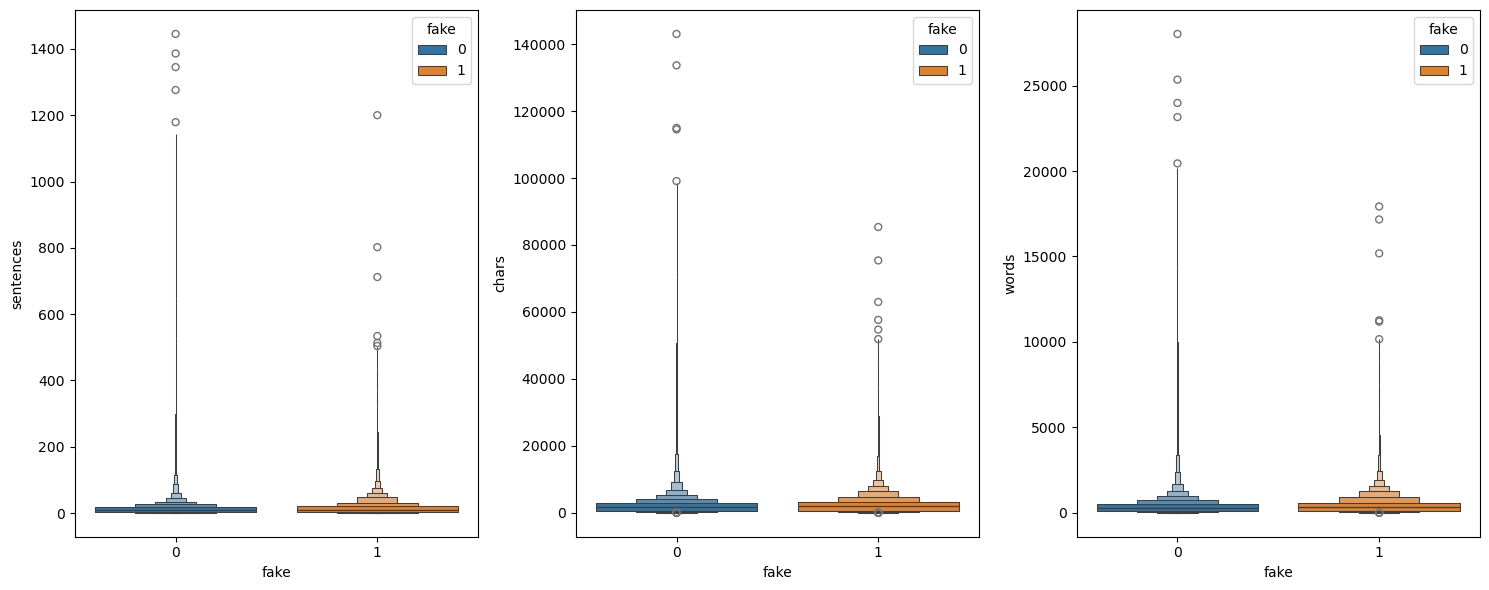

In [17]:
ninja_utils.plot_plots_dataset(dataset_all)

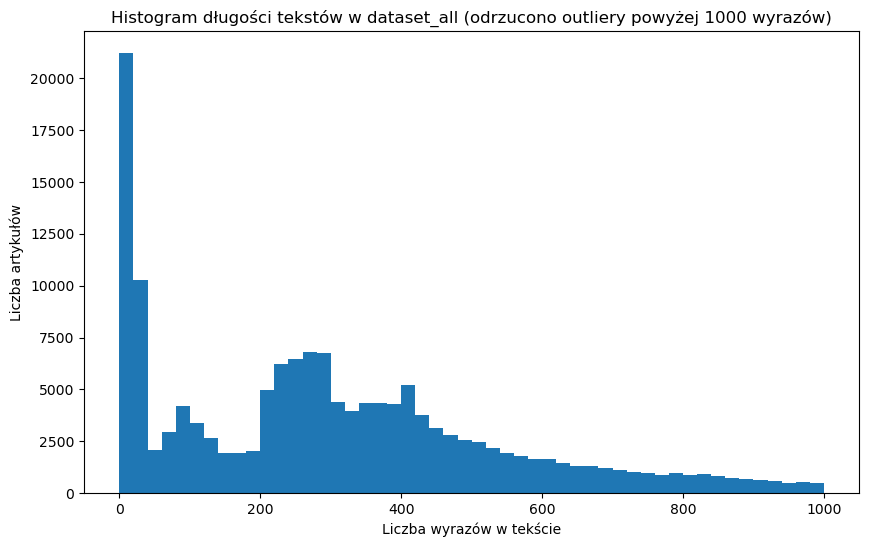

In [44]:
# histogram dlugosci tekstow (wyrazow) w dataset_all, odrzucic outliery powyzej 1000 wyrazow
dataset_all['text_length'] = dataset_all['text'].apply(lambda x: len(str(x).split()))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(dataset_all['text_length'], bins=50, range=(0, 1000))
plt.xlabel('Liczba wyrazów w tekście')
plt.ylabel('Liczba artykułów')
plt.title('Histogram długości tekstów w dataset_all (odrzucono outliery powyżej 1000 wyrazów)')
plt.show()

## filtrowanie po jezyku angielskim

In [18]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=f5928ee21988006db2536cec9c42e7d42ff9c2c0ae6207f683aeca17965374d4
  Stored in directory: /Users/dominikakokoryk/Library/Caches/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [19]:
from langdetect import detect

In [20]:
dataset_all.shape

(160960, 5)

In [21]:
## filtrowanie dataset_all po jezyku angielskim, usunięcie wierszy z innym języku
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

dataset_all = dataset_all[dataset_all['text'].apply(is_english)]
dataset_all.shape

(160265, 5)

## Lematyzacja, usuwanie stopwords, wektoryzacja, filtrowanie po jezyku

In [24]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [28]:
import ninja_utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dominikakokoryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dominikakokoryk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# preprocessing text: lowercasing, removing punctuation, lemmatization, removing stopwords
dataset_all['processed_text'] = dataset_all['text'].apply(ninja_utils.preprocess_text)
dataset_all.head()

,text,fake,chars,sentences,words,processed_text
0,"While serving as U.S. Vice President, Henry A....",0,116,1,21,serving u vice president henry a wallace wrote...
1,A 1964 campaign ad for President Lyndon B. Joh...,0,166,1,28,1964 campaign ad president lyndon b johnson fe...
2,Fifty Republican former national security offi...,0,161,1,24,fifty republican former national security offi...
3,Elon Musk deleted a tweet where he called the ...,0,92,1,15,elon musk deleted tweet called mastodon social...
4,Texas Lt. Gov. Dan Patrick said COVID-19 socia...,0,140,2,22,texas lt gov dan patrick said covid19 socialdi...


## eksperymenty z modelami

In [31]:
# 20 to liczba slow do podzialu na dwa datasety - krotkie i dlugie
# datasety krotkie i dlugie beda potem uzyte do trenowania modeli
dataset_short = dataset_all[dataset_all['words'] <= 20]
dataset_long = dataset_all[dataset_all['words'] > 20]
dataset_short.shape, dataset_long.shape

((19323, 6), (140942, 6))

In [35]:
# wyciagnij losowo 20000 probek z dataset_long
dataset_short_sample = dataset_short
dataset_long_sample = dataset_long.sample(n=20000, random_state=42)
dataset_short_sample.shape, dataset_long_sample.shape

((19323, 6), (20000, 6))

In [36]:
# vectorize processed_text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_short = vectorizer.fit_transform(dataset_short_sample['processed_text']).toarray()
X_long = vectorizer.fit_transform(dataset_long_sample['processed_text']).toarray()
y_short = dataset_short_sample['fake'].values
y_long = dataset_long_sample['fake'].values

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, precision_score
import seaborn as sns

In [50]:
X_short_train, X_short_test, y_short_train, y_short_test = train_test_split(X_short, y_short, test_size=0.2, random_state=42, stratify=y_short)
X_long_train, X_long_test, y_long_train, y_long_test = train_test_split(X_long, y_long, test_size=0.2, random_state=42, stratify=y_long)

In [ ]:
# def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
#     # print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     return confusion_matrix(y_test, y_pred)

In [52]:
def train_model_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # policz acuracy, precision i fbeta
    fbeta_res = fbeta_score(y_test, y_pred, beta=0.5)
    accuracy_res = accuracy_score(y_test, y_pred)
    precision_res = precision_score(y_test, y_pred)
    res_key = type(model).__name__
    res_val = f"fbeta: {fbeta_res:.2f}, accuracy: {accuracy_res:.2f}, precision: {precision_res:.2f}"
    print(f"{res_key}, {res_val}")
    return (res_key, res_val)


### Wyniki ogolne klasyfikatorow

In [54]:
lrr = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(random_state=42)
# dtc = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='error', random_state=42)
knn = KNeighborsClassifier()
svc = SVC(random_state=42)
short_results = []
long_results = []

models = [lrr, rfc, xgb, knn, svc]
print("Short texts (<= 20 words):")
for model in models:
    short_results.append(train_model_and_evaluate(model, X_short_train, y_short_train, X_short_test, y_short_test))

print("Long texts (> 20 words):")
for model in models:
    long_results.append(train_model_and_evaluate(model, X_long_train, y_long_train, X_long_test, y_long_test))



Short texts (<= 20 words):
LogisticRegression, fbeta: 0.72, accuracy: 0.69, precision: 0.71
RandomForestClassifier, fbeta: 0.73, accuracy: 0.69, precision: 0.73
XGBClassifier, fbeta: 0.70, accuracy: 0.66, precision: 0.67
KNeighborsClassifier, fbeta: 0.18, accuracy: 0.44, precision: 0.87
SVC, fbeta: 0.73, accuracy: 0.70, precision: 0.72
Long texts (> 20 words):
LogisticRegression, fbeta: 0.57, accuracy: 0.57, precision: 0.57
RandomForestClassifier, fbeta: 0.55, accuracy: 0.54, precision: 0.55
XGBClassifier, fbeta: 0.56, accuracy: 0.56, precision: 0.57
KNeighborsClassifier, fbeta: 0.53, accuracy: 0.52, precision: 0.52
SVC, fbeta: 0.55, accuracy: 0.55, precision: 0.56


In [64]:
dataset_short.head()

,text,fake,chars,sentences,words,processed_text
3,Elon Musk deleted a tweet where he called the ...,0,92,1,15,elon musk deleted tweet called mastodon social...
5,A photograph shows a man giving Mitch McConnel...,0,84,1,15,photograph show man giving mitch mcconnell thu...
8,"In January 2022, a Boston hospital denied a pa...",0,111,1,19,january 2022 boston hospital denied patient he...
9,E-mail reproduces Rev. Jesse Lee Peterson's ed...,0,109,2,19,email reproduces rev jesse lee petersons edito...
10,A photograph shows the Arch of Baal erected on...,0,84,1,17,photograph show arch baal erected national mal...


In [ ]:
X_short = vectorizer.fit_transform(dataset_short_sample['processed_text']).toarray()
y_short = dataset_short_sample['fake'].values

In [67]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    return model

In [73]:
def print_metrics_of_classifier(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    class_report_dict = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='viridis')
    plt.xlabel("predicted values")
    plt.ylabel("true value")
    plt.show()

    # print(f"{type(classifier).__name__}: recall: {class_report_dict['True']['recall']:.2f}, precision: {class_report_dict['True']['precision']:.2f}")


## RandomForestClassifier

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1629
           1       0.73      0.73      0.73      2236

    accuracy                           0.69      3865
   macro avg       0.68      0.68      0.68      3865
weighted avg       0.69      0.69      0.69      3865

Accuracy: 0.6869340232858991
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1629
           1       0.73      0.73      0.73      2236

    accuracy                           0.69      3865
   macro avg       0.68      0.68      0.68      3865
weighted avg       0.69      0.69      0.69      3865



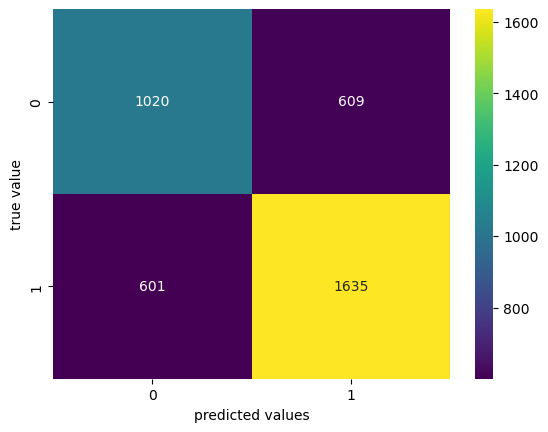

In [78]:
# wezmiemy model random forest, poszukajmy najlepszych parametrow dla data_short

rf_model = RandomForestClassifier(random_state=42)
train_model(rf_model, X_short_train, y_short_train, X_short_test, y_short_test)
print_metrics_of_classifier(rf_model, X_short_test, y_short_test)

In [84]:
import joblib

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.579 total time=   1.0s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.579 total time=   0.6s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.579 total time=   0.6s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.579 total time=   1.0s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.579 total time=   1.1s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.579 total time=   1.1s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.579 total time=   2.0s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.579 total time=   2.4s
[CV 3

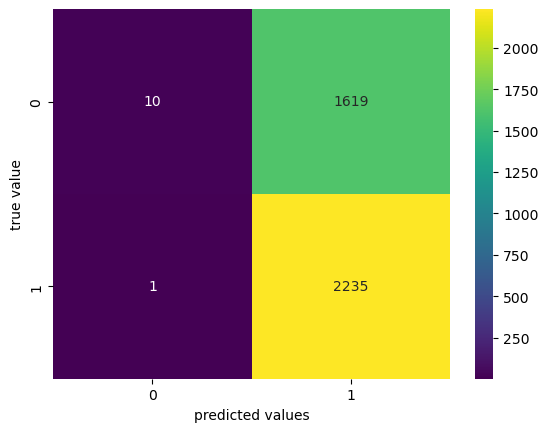

In [79]:
# cross validation & hyperparameter tuning dla random forest
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=4)
grid_search.fit(X_short_train, y_short_train)
print("Best parameters found: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
print_metrics_of_classifier(best_rf_model, X_short_test, y_short_test)

In [87]:
# save model
with open('temp/text_model.pkl', 'wb') as model_file:
    joblib.dump(best_rf_model, model_file)

# save vectorizer
with open('temp/text_vectorizer.pkl', 'wb') as vec_file:
    joblib.dump(vectorizer, vec_file)

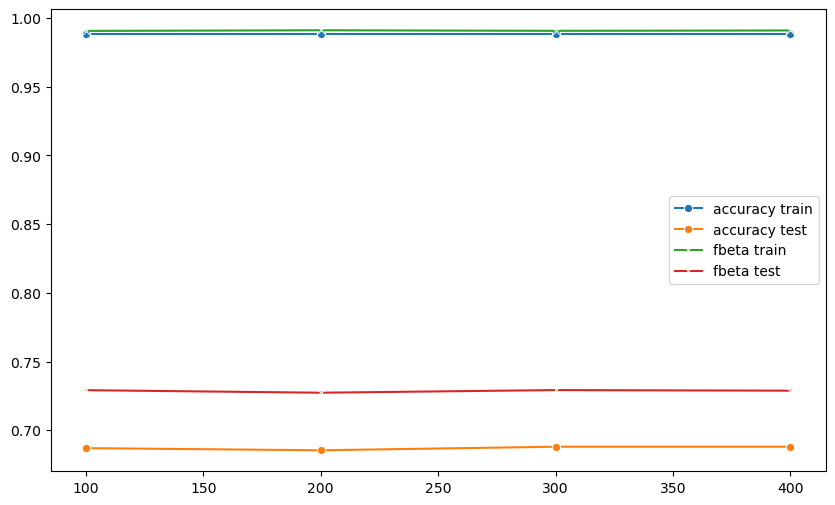

In [83]:
n_estimators = list(range(100, 500, 100))
nest_accuracy_train = []
nest_accuracy_test = []
nest_fbeta_train = []
nest_fbeta_test = []
for nest in n_estimators:
    classifier = RandomForestClassifier(random_state=42, n_estimators=nest)
    classifier.fit(X_short_train, y_short_train)
    y_pred = classifier.predict(X_short_test)
    y_pred_train = classifier.predict(X_short_train)
    nest_fbeta_test.append(fbeta_score(y_true=y_short_test, y_pred=y_pred, beta=0.5))
    nest_fbeta_train.append(fbeta_score(y_true=y_short_train, y_pred=y_pred_train, beta=0.5))
    nest_accuracy_test.append(accuracy_score(y_short_test, y_pred))
    nest_accuracy_train.append(accuracy_score(y_short_train, y_pred_train))

plt.figure(figsize=(10, 6))
sns.lineplot(x=n_estimators, y=nest_accuracy_train,  marker='o', label='accuracy train')
sns.lineplot(x=n_estimators, y=nest_accuracy_test, marker='o', label='accuracy test')
sns.lineplot(x=n_estimators, y=nest_fbeta_train, marker='x', label='fbeta train')
sns.lineplot(x=n_estimators, y=nest_fbeta_test, marker='x', label='fbeta test')
plt.legend()
plt.show()

In [ ]:
min_samples_leaf = list(range(1, 20, 2))

samples_accuracy_train = []
samples_accuracy_test = []
samples_fbeta_train = []
samples_fbeta_test = []
for samples in min_samples_leaf:
    classifier = RandomForestClassifier(random_state=42, min_samples_leaf=samples)
    classifier.fit(X_short_train, y_short_train)
    y_pred = classifier.predict(X_short_test)
    y_pred_train = classifier.predict(X_short_train)
    samples_accuracy_train.append(accuracy_score(y_short_train, y_pred_train))
    samples_accuracy_test.append(accuracy_score(y_short_test, y_pred))
    samples_fbeta_train.append(fbeta_score(y_true=y_short_train, y_pred=y_pred_train, beta=0.5))
    samples_fbeta_test.append(fbeta_score(y_true=y_short_test, y_pred=y_pred, beta=0.5))

plt.figure(figsize=(10, 6))
sns.lineplot(x=min_samples_leaf, y=samples_accuracy_train,  marker='o', label='accuracy train')
sns.lineplot(x=min_samples_leaf, y=samples_accuracy_test, marker='o', label='accuracy test')
sns.lineplot(x=min_samples_leaf, y=samples_fbeta_train, marker='x', label='fbeta train')
sns.lineplot(x=min_samples_leaf, y=samples_fbeta_test, marker='x', label='fbeta test')
plt.legend()
plt.show()

In [ ]:
import sys
sys.path.append("..")
import scripts.data_utils as dutils

daaaaa = dutils.load_datasets()